Imports

In [ ]:
! pip install -r requirements.txt

In [15]:
import os
import yaml
import warnings
import numpy as np
import nibabel as nib
from skimage import exposure
import matplotlib.pyplot as plt
from skimage.filters import frangi
warnings.filterwarnings("ignore")

Configuration

In [38]:
with open('config/config.yml', 'r') as file: config = yaml.safe_load(file)

data_path = config['paths']['data']
outputs_dir = config['paths']['outputs']
results_dir = config['paths']['results']
stride = config['filter']['stride']
threshold = config['filter']['threshold']

os.makedirs(results_dir, exist_ok=True)
os.makedirs(outputs_dir, exist_ok=True)

Load brainmask

In [39]:
brainmask_img = nib.load(data_path)
brainmask_data = brainmask_img.get_fdata()

PVS mask

In [ ]:
# Normalize the T1 image
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))
normalized_t1 = normalize_image(brainmask_data)

# Apply Frangi Filter
frangi_params = {"sigmas": np.arange(0, 1, stride), "black_ridges": False} # Set to True if PVS appears darker
pvs_mask = frangi(normalized_t1, **frangi_params)

# Save the output
output_path = f"{outputs_dir}/pvs_mask_s{stride}.nii.gz"
output_img = nib.Nifti1Image(pvs_mask, brainmask_img.affine)
nib.save(output_img, output_path)
print(f"PVS mask saved to {output_path}")

In [40]:
pvs_mask = nib.load(f"{outputs_dir}/pvs_mask_s{stride}.nii.gz").get_fdata()

Threshold the PVS mask

In [41]:
pvs_mask_norm = (pvs_mask - np.mean(pvs_mask))/np.std(pvs_mask)
binary_mask = pvs_mask_norm > threshold

2D visualization

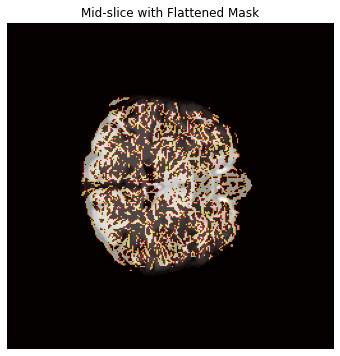

In [44]:
mid_slice_idx = brainmask_data.shape[2] // 2
background = normalized_t1[:, :, mid_slice_idx]

flattened_mask = np.max(binary_mask, axis=2)

plt.figure(figsize=(6, 6))
plt.imshow(background, cmap="gray", alpha=1)
plt.imshow(flattened_mask, cmap="hot", alpha=0.6)
plt.title(f"Mid-slice with Flattened Mask")
plt.axis("off")
plt.savefig(f"{results_dir}/pvs_mask_s{stride}_t{threshold}_2d.jpg")
plt.show()

In [45]:
# Save the output
output_path = f"{outputs_dir}/pvs_mask_s{stride}_t{threshold}.nii.gz"
output_img = nib.Nifti1Image(binary_mask.astype(np.uint8), brainmask_img.affine)
nib.save(output_img, output_path)
print(f"PVS Binary mask saved to {output_path}")

PVS Binary mask saved to outputs/pvs_mask_s0.05_t9.nii.gz


In [46]:
binary_mask = nib.load(f"{outputs_dir}/pvs_mask_s{stride}_t{threshold}.nii.gz").get_fdata()

3D visualization

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_1216\1529744469.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{results_dir}/pvs_mask_s{stride}_t{threshold}_3d.jpg")
c:\Users\Mostafa\anaconda3\envs\neuroimaging\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


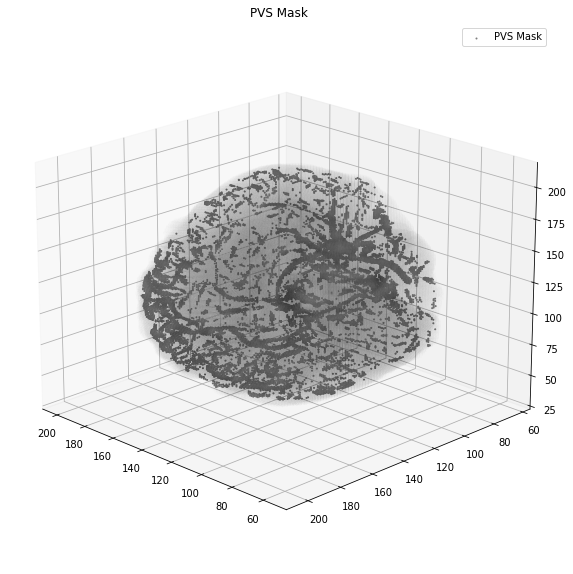

In [47]:
brain_data = normalized_t1
mask_data = binary_mask

x, y, z = np.nonzero(brain_data)
y = brain_data.shape[1] - y
mask_x, mask_y, mask_z = np.nonzero(mask_data)
mask_y = mask_data.shape[1] - mask_y

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z, c=brain_data[x, brain_data.shape[1] - y, z], cmap="gray", alpha=0.01, s=0.1)
ax.scatter(mask_x, mask_y, mask_z, c="gray", label="PVS Mask", alpha=1, s=1)

ax.set_title("PVS Mask")
ax.legend()
ax.view_init(elev=20, azim=135)
plt.savefig(f"{results_dir}/pvs_mask_s{stride}_t{threshold}_3d.jpg")
plt.show()